<a href="https://colab.research.google.com/github/pe44enka/TaxiFarePrediction/blob/master/TaxiFarePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NYC Taxi Fare Prediction**

![](https://static.vecteezy.com/system/resources/previews/000/118/272/original/free-new-york-taxi-watercolor-vector.jpg)


### **Objectives**

Imagine you are in Big Apple. New to town and have no clue how to get from Central park to Empire State Building. After some useless attemps and short fair buttle you finally got your cab. But hey! How much is it gonna cost you in this crazy city?


---

### **Goal of the project**
To predict the fare amount for a taxi ride in New York City given the pickup and dropoff locations.

### **Data**
[New York City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction) dataset available at Kaggle as part of competition.

The dataset contains the following fields:

Field name | Description
--- |--- 
*key* | identifier for each trip
*fare_amount* | the cost of each trip in usd
*pickup_datetime* | date and time when the meter was engaged
*passenger_count* | the number of passengers in the vehicle (driver entered value)
*pickup_longitude* | the longitude where the meter was engaged
*pickup_latitude* | the latitude where the meter was engaged
*dropoff_longitude* | the longitude where the meter was disengaged
*dropoff_latitude* | the latitude where the meter was disengaged

### **Techniques**
In this project we will use:
* **Data preprocessing**: SelectFromModel, SimpleImputer, OneHotEncoder, StandardScaler, ColumnTransformer, pandas.get_dummies
* **ML algorihms**: LinearRegression, DecisionTreeRegressor RandomForestRegressor, GradientBoostingRegressor, XGBRegressor 
* **Hyperparameter turning:** GridSearchCV
* **Model training/applying:** Pipeline, tran_test_split


---

# Load Libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from geopy.distance import great_circle

# Load Data

In [121]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/pe44enka/TaxiFarePrediction/master/data/train.csv')
print('raw_df.shape: ', raw_df.shape)
raw_df.head()

raw_df.shape:  (1048575, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data Cleaning

## Overview


Before playing with ML models and trying to predict anything let's get ourselves familiar with data we have.

---



In [122]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1048575 non-null  object 
 1   fare_amount        1048575 non-null  float64
 2   pickup_datetime    1048575 non-null  object 
 3   pickup_longitude   1048575 non-null  float64
 4   pickup_latitude    1048575 non-null  float64
 5   dropoff_longitude  1048565 non-null  float64
 6   dropoff_latitude   1048565 non-null  float64
 7   passenger_count    1048575 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 64.0+ MB



---

**Notes:** there are mixed categorical and numerical features as well as missing values in the data

**Conclusion:** need to get rid of missing values and to deal with categorical data

---



## Missing Values

Let's have a look on features with missing values.

---

In [123]:
raw_df[raw_df.columns[raw_df.isnull().sum().values>0]].isna().sum()

dropoff_longitude    10
dropoff_latitude     10
dtype: int64



---

As we can see ```dropoff_longitude``` and ```dropoff_latitude``` have missing values.
As long as it's unavailable to fill these gaps with any known values and amount of missing values is not high in comparison with all entities in the data (<0.001%), I will just skip these entities with dropping the whole row. 


---



In [124]:
df = raw_df.dropna(axis=0) #drop rows with NaN
df.reset_index(drop=True, inplace=True) #reset index after dropping rows
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [125]:
print('df.shape: ', df.shape)
df.head()

df.shape:  (1048565, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [126]:
df[df.columns[df.isnull().sum().values>0]].isna().sum()

Series([], dtype: float64)



---

There is no missing values in the data.

---



## Coordinate Columns Values

Before getting distance of rides out of coordinate columns (```'pickup_latitude```, ```pickup_longitude```, ```dropoff_latitude``` and ```dropoff_longitude```) we need to check if their values lie in range (-90, 90) degrees. Let's check descriptive statistic on these columns.

---

In [127]:
df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.048565e+06,1.048565e+06,1.048565e+06,1.048565e+06
mean,3.993097e+01,-7.252729e+01,3.992496e+01,-7.252750e+01
std,7.725744e+00,1.200783e+01,8.529585e+00,1.141154e+01
min,-3.116285e+03,-3.377681e+03,-3.114339e+03,-3.383297e+03
25%,4.073496e+01,-7.399207e+01,4.073406e+01,-7.399138e+01
50%,4.075267e+01,-7.398180e+01,4.075318e+01,-7.398014e+01
75%,4.076714e+01,-7.396711e+01,4.076812e+01,-7.396367e+01
max,2.621628e+03,2.522271e+03,1.989728e+03,1.717003e+03



---

As we can see all coordinate columns have *min* and *max* values far away from -90 and 90 where they are supposed to be. Let's check how many entities have coordinates lower than -90 and higher than 90.

---



In [128]:
#concatenate parts of the data cutted accordingly to the conditions described above
coor_df = pd.concat([df[df.pickup_latitude < - 90], df[df.pickup_latitude > 90],
                     df[df.pickup_longitude < - 90], df[df.pickup_longitude > 90],
                     df[df.dropoff_latitude < - 90], df[df.dropoff_latitude > 90],
                     df[df.dropoff_longitude < - 90], df[df.dropoff_longitude > 90]
                     ])
coor_df = coor_df.drop_duplicates() #remove duplicated rows
coor_df.shape

(49, 8)



---

There are a few values in coordinate columns that do not follow the condition. These amount is not high in comparison with all entities in the data (<0.005%), I will skip these entities with dropping the whole row.

---



In [129]:
df.drop(index=coor_df.index.to_list(), inplace=True)
print('df.shape: ', df.shape)
df.head()

df.shape:  (1048516, 8)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [130]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.048516e+06,1.048516e+06,1.048516e+06,1.048516e+06,1.048516e+06,1.048516e+06
mean,1.134531e+01,-7.251788e+01,3.992727e+01,-7.251708e+01,3.992701e+01,1.684913e+00
std,9.819766e+00,1.039017e+01,6.086952e+00,1.039004e+01,6.089382e+00,1.323140e+00
min,-4.490000e+01,-8.943979e+01,-7.401659e+01,-8.680412e+01,-7.403520e+01,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073496e+01,-7.399138e+01,4.073406e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075267e+01,-7.398014e+01,4.075318e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076714e+01,-7.396367e+01,4.076812e+01,2.000000e+00
max,5.000000e+02,4.085036e+01,6.940000e+01,4.558162e+01,8.151018e+01,2.080000e+02




---
All coordinates are in required range.

Let's also check the data with null coordinates.

---



In [131]:
null_coor_df = pd.concat([df[df.pickup_latitude == 0], df[df.pickup_longitude == 0],
                          df[df.dropoff_latitude == 0], df[df.dropoff_longitude == 0]])
                    
null_coor_df = null_coor_df.drop_duplicates() #remove duplicated rows
null_coor_df.shape

(20595, 8)



---

There are a lot of entities with zero coordinates what means that it brings us no information about the distance of particular rides and makes this entities senseless and potentially dangeroud for future model training as far as it can lead to wrong predictions. 

I will treat these zero values as missing values. There is no way I can find info and fill them with certain values. And although it's about 0.2% of the data I will drop them anyway to avoid wrong model training. 

---



In [132]:
df.drop(index=null_coor_df.index.to_list(), inplace=True)
print('df.shape: ', df.shape)
df.head()

df.shape:  (1027921, 8)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [133]:
null_coor_df = pd.concat([df[df.pickup_latitude == 0], df[df.pickup_longitude == 0],
                          df[df.dropoff_latitude == 0], df[df.dropoff_longitude == 0]])
                    
null_coor_df = null_coor_df.drop_duplicates() #remove duplicated rows
null_coor_df.shape

(0, 8)



---

No entities with zero coordinates left.

---



## Feature Engineering

Let's transform data features to make them more useful for future modeling.

---

### Columns Dropping

I will drop ```key``` column as far as it's just indicator of the ride and brings no useful info for further analysis and modeling.

----

In [134]:
df.drop(columns=['key'], inplace=True) #remove key column
print('df.shape: ', df.shape)
df.head()

df.shape:  (1027921, 7)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Column Creating

#### Datetime Columns



On next step I will parse ```pickup_datetime``` feature into several columns:
* year
* season
* month_name
* day
* day_name
* hour
* rush hour (yes/no): 7am - 10 am, 3pm - 7pm

By default all datetime based columns are considered as strings in pandas. So at first I will convert string to datetime data type and then extract from datetime object all information wI need.

---



In [135]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dtypes

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [136]:
df['year'] = df.pickup_datetime.dt.year #year

#getting seasons for each entity
seasons = ['Winter', 'Spring', 'Summer', 'Fall'] #season
df['season'] = [seasons[i-1] for i in (df.pickup_datetime.dt.month%12// 3 + 1).values]

df['month'] = df.pickup_datetime.dt.month_name() #month
df['day'] = df.pickup_datetime.dt.day #day
df['day_name'] = df.pickup_datetime.dt.day_name() #day name
df['hour'] = df.pickup_datetime.dt.hour #hour

#finding out if the ride was in rush hour (7am-10am, 3pm-7pm) or not
rush_hour = []
for i in df.hour.values:
  if i in range(7,11):
    rush_hour.append(1)
  elif i in range(15,20):
    rush_hour.append(1)
  else:
    rush_hour.append(0)
df['rush_hour'] = rush_hour

df.drop(columns=['pickup_datetime'], inplace=True) # drop donor column

print('df.shape: ', df.shape)
df.head()

<ipython-input-136-bc2ae203499d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.pickup_datetime.dt.year #year
<ipython-input-136-bc2ae203499d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'] = [seasons[i-1] for i in (df.pickup_datetime.dt.month%12// 3 + 1).values]
<ipython-input-136-bc2ae203499d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

df.shape:  (1027921, 13)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1


#### Distance Column



One of the most important metrics influncing on the taxi ride fare is distance. To get it we will need to convert latitude and longitude of pick up and drop off into km.

For this purpose I will use **Haversine (or great circle) distance** - the angular distance between two points on the surface of a sphere. The first coordinate of each point is assumed to be the latitude, the second is the longitude.

If speaking on Python we can do it by defining a custom function or by using different libraries:
* ```from geopy.distance import great_circle```
* ```sklearn.neighbors```
* ```from sklearn.metrics.pairwise import haversine_distances```


In this project I will use ```geopy``` library. Let's check how it works on the first ride in the data.

---



In [137]:
coordA = [df.pickup_latitude.iloc[0], df.pickup_longitude.iloc[0]]
coordB = [df.dropoff_latitude.iloc[0], df.dropoff_longitude.iloc[0]]
print ('Distance is: {:.3f} km'.format(float(great_circle(coordA, coordB).kilometers)))

Distance is: 1.031 km




---

Now when I know how to count the distance for 1 entity I just need to put the code in loop and get the distance for each of them. Let's do it!

---



In [138]:
distance = []
for i in range(df.shape[0]):
  coordA = [df.pickup_latitude.iloc[i], df.pickup_longitude.iloc[i]]
  coordB = [df.dropoff_latitude.iloc[i], df.dropoff_longitude.iloc[i]]
  distance.append(round(float(great_circle(coordA, coordB).kilometers), 3))

df['distance'] = distance #create a column with distance for each ride
#df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True) #drop donor columns

print('df.shape: ', df.shape)
df.head()

df.shape:  (1027921, 14)


<ipython-input-138-4572a4506a32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = distance #create a column with distance for each ride


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


## Pre-processing Data

### Overview

Once I've done with feature creating it's time to explore the data.

---

In [139]:
df.describe(include='all')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
count,1.027921e+06,1.027921e+06,1.027921e+06,1.027921e+06,1.027921e+06,1.027921e+06,1.027921e+06,1027921,1027921,1.027921e+06,1027921,1.027921e+06,1.027921e+06,1.027921e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,NaN,7,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,May,NaN,Friday,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287226,96323,NaN,158583,NaN,NaN,NaN
mean,1.133004e+01,-7.390644e+01,4.068914e+01,-7.390595e+01,4.068934e+01,1.685244e+00,2.011739e+03,NaN,NaN,1.569820e+01,NaN,1.350912e+01,4.353185e-01,4.395170e+00
std,9.746336e+00,2.721070e+00,2.600426e+00,2.716004e+00,2.601251e+00,1.307981e+00,1.862741e+00,NaN,NaN,8.680878e+00,NaN,6.511469e+00,4.957989e-01,7.550311e+01
min,-4.490000e+01,-8.061666e+01,-7.401659e+01,-8.680412e+01,-7.403520e+01,0.000000e+00,2.009000e+03,NaN,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073653e+01,-7.399157e+01,4.073553e+01,1.000000e+00,2.010000e+03,NaN,NaN,8.000000e+00,NaN,9.000000e+00,0.000000e+00,1.254000e+00
50%,8.500000e+00,-7.398208e+01,4.075336e+01,-7.398058e+01,4.075386e+01,1.000000e+00,2.012000e+03,NaN,NaN,1.600000e+01,NaN,1.400000e+01,0.000000e+00,2.153000e+00
75%,1.250000e+01,-7.396829e+01,4.076755e+01,-7.396528e+01,4.076841e+01,2.000000e+00,2.013000e+03,NaN,NaN,2.300000e+01,NaN,1.900000e+01,1.000000e+00,3.918000e+00


---

**Notes:** 
* target column ```fare_amount```: *min* value is negative. That means that some entities in the data has negative price for taxi ride what is an obvious error and can lead to wrong training of the model
* ```passenger_count``` column *min* is zero and *max* is 9 passengers both of which are impossible
* ```distance``` column: *min* value is zero what is senseless and can be considered as missing values

**Conclusion:** closely observe
* ```fare_amount``` column to deal with negative values
* ```passenger_count``` column to check that number of passengers per cab is realistic
* ```distance``` column to check for zero values

---

### Target Feature Values


As it was mentioned earlier, we need to get rid of negative values in the target column ```fare_amount```. We also should check if there is any zero values in the target column as far as it brings no info for the future model and can be counted and treated as missing values.


---

In [140]:
df.fare_amount.describe()

count    1.027921e+06
mean     1.133004e+01
std      9.746336e+00
min     -4.490000e+01
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      5.000000e+02
Name: fare_amount, dtype: float64

In [141]:
df[df.fare_amount<=0].shape #amount of negative and zero values for fare_amount column

(60, 14)

---

As we can see there are some negative and zero values in ```fare_amount``` column. These amount is not high in comparison with all entities in the data (~0.006%), I will skip these entities with dropping the whole row.

---

In [142]:
df = df[df.fare_amount>0]
print('df.shape: ', df.shape)
df.head()

df.shape:  (1027861, 14)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


In [143]:
df[df.fare_amount<=0].shape

(0, 14)



---

No entities with negative or null ride price left.


---



In [144]:
df.fare_amount.describe()

count    1.027861e+06
mean     1.133091e+01
std      9.745803e+00
min      1.000000e-02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      5.000000e+02
Name: fare_amount, dtype: float64



---

Now *min* of ```fare_amount``` is $0.01 what is still pretty low and seems erroneous. 

---



In [145]:
df[df.fare_amount<1]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
2780,0.01,-73.939041,40.713963,-73.941673,40.713997,1,2015,Spring,May,1,Friday,15,1,0.222
90010,0.01,-73.980331,40.770535,-73.981911,40.771503,1,2015,Winter,February,19,Thursday,6,0,0.171
194168,0.01,-73.890549,40.719757,-73.842293,40.668804,2,2015,Winter,February,27,Friday,15,1,6.975
217966,0.01,-73.997398,40.725941,-73.997421,40.725983,1,2015,Winter,January,14,Wednesday,16,1,0.005
281140,0.01,-73.757896,40.927608,-73.757896,40.927605,1,2015,Spring,April,13,Monday,21,0,0.000
671865,0.01,-73.980535,40.779988,-73.970821,40.793403,1,2010,Winter,February,2,Tuesday,17,1,1.701
843937,0.01,-73.996124,40.753342,-73.998871,40.755047,1,2015,Spring,March,29,Sunday,10,1,0.299
1030274,0.01,-73.972466,40.786537,-73.972473,40.786541,1,2015,Spring,March,17,Tuesday,23,0,0.001
1046329,0.01,-73.977928,40.783142,-73.977936,40.783180,2,2015,Winter,January,5,Monday,21,0,0.004




---

There are also not so many entities with this ```fare_amount``` < $1, so I will drop them as well.

---



In [146]:
df.drop(index=df[df.fare_amount<1].index.to_list(), inplace=True)
print('df.shape: ', df.shape)
df.head()

df.shape:  (1027852, 14)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


In [147]:
df.fare_amount.describe()

count    1.027852e+06
mean     1.133101e+01
std      9.745788e+00
min      2.500000e+00
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      5.000000e+02
Name: fare_amount, dtype: float64



---

Finally, ```fare_amount```  *min* looks realistic.

---





### Passenger_count Feature Values

Let's check how many unique values ```passenger_count``` column has.

---

In [148]:
df.passenger_count.unique()

array([1, 2, 3, 6, 5, 4, 0, 9])

---

With assumption that the largest car that can work in taxi is a mini van with 6 possible passengers, I can determine that ```passenger_count``` column should have values in range (1,6).

As shown the data has 2 additional number of passengers: 0 and 9. Let's see how many entities have these values.

---

In [149]:
print('0 passengers: {}\n9 passengers: {}'.format(df[df.passenger_count==0].shape[0], df[df.passenger_count==9].shape[0]))

0 passengers: 3639
9 passengers: 1





---

As shown there are just 1 entity with more passengers than 6, we can drop this entity.

But there are a lot entities with 0 passengers. As long as taxi ride can't be without a passenger, we will place 1 passenger to each of those rides.

---



In [150]:
df = df[df.passenger_count<7] #drop rows with passenger_count > 6
df.passenger_count.replace(0,1, inplace=True) #replacing 0 with 1

print('df.shape: ', df.shape)
df.head()

df.shape:  (1027851, 14)


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


In [151]:
df.passenger_count.describe()

count    1.027851e+06
mean     1.688790e+00
std      1.304756e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64



---

```passenger_count``` column has *min* 1 passenger and *max* 6 passengers.

---



### Distance Feature Values

In [152]:
df.distance.describe()

count    1.027851e+06
mean     4.395349e+00
std      7.550567e+01
min      0.000000e+00
25%      1.254000e+00
50%      2.153000e+00
75%      3.918000e+00
max      1.259472e+04
Name: distance, dtype: float64



---

As we can see *min* of ```distance``` column is zero. What makes me think there are some mistaken coordinates in the data which shouldn't be used in model training. That's why I will drop entities connected with them.


---



In [153]:
df[df.distance==0].shape

(11494, 14)

In [154]:
df[df.distance==0][['fare_amount', 'distance']].head()

,fare_amount,distance
105,52.0,0.0
191,6.5,0.0
270,7.5,0.0
290,6.9,0.0
396,12.0,0.0




---

As shown there are rides with zero distance but not zero fare amount. That's why I can make an assumption that data was colllected not correctly. As long as I can't get info to fill these gaps from any source and this can influent future model I will drop the whole entity connected to particular zero (about 1.1% of the data).

---



In [157]:
df = df[df.distance > 0]
print('df.shape: ', df.shape)
df.head()

df.shape:  (1016357, 14)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


In [158]:
df.distance.describe()

count    1.016357e+06
mean     4.445057e+00
std      7.592996e+01
min      1.000000e-03
25%      1.279000e+00
50%      2.179000e+00
75%      3.951000e+00
max      1.259472e+04
Name: distance, dtype: float64



---

*min* value is still pretty low (1 meter). Taxi ride with distance less than at least 100m  doesn't make sense and seems erroneous. And as tradition, I will drop these entities (~0.2%).

---



In [159]:
df[df.distance<0.01].shape

(1958, 14)

In [160]:
df.drop(index=df[df.distance<0.01].index.to_list(), inplace=True)
print('df.shape: ', df.shape)
df.head()

df.shape:  (1014399, 14)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,Summer,June,15,Monday,17,1,1.031
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999


In [161]:
df.distance.describe()

count    1.014399e+06
mean     4.453630e+00
std      7.600296e+01
min      1.000000e-02
25%      1.284000e+00
50%      2.183000e+00
75%      3.957000e+00
max      1.259472e+04
Name: distance, dtype: float64



---

Finally, *min* distance of the ride looks realistic.

---



### Duplicates


Also to avoid false influence on the result by same data, let's check it on duplicates.

---

In [162]:
df.nunique() #Count number of distinct elements in specified axis

fare_amount            2040
pickup_longitude     112334
pickup_latitude      144825
dropoff_longitude    134276
dropoff_latitude     172330
passenger_count           6
year                      7
season                    4
month                    12
day                      31
day_name                  7
hour                     24
rush_hour                 2
distance              23700
dtype: int64

In [163]:
df.duplicated().sum() #count sum of  boolean Series denoting duplicate rows

0



---

There is no duplicated rows in the data.

---



# Eploratory Data Analysis & Feature Selection

## Overview

In [167]:
df.describe(include='all')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
count,1.014399e+06,1.014399e+06,1.014399e+06,1.014399e+06,1.014399e+06,1.014399e+06,1.014399e+06,1014399,1014399,1.014399e+06,1014399,1.014399e+06,1.014399e+06,1.014399e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12,NaN,7,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,May,NaN,Friday,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283496,95079,NaN,156478,NaN,NaN,NaN
mean,1.130262e+01,-7.390709e+01,4.068909e+01,-7.390661e+01,4.068929e+01,1.689383e+00,2.011745e+03,NaN,NaN,1.569615e+01,NaN,1.351210e+01,4.352824e-01,4.453630e+00
std,9.504164e+00,2.718510e+00,2.603051e+00,2.713371e+00,2.603886e+00,1.305015e+00,1.863616e+00,NaN,NaN,8.681410e+00,NaN,6.511199e+00,4.957942e-01,7.600296e+01
min,2.500000e+00,-8.061666e+01,-7.401659e+01,-8.680412e+01,-7.403520e+01,1.000000e+00,2.009000e+03,NaN,NaN,1.000000e+00,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399157e+01,4.073558e+01,1.000000e+00,2.010000e+03,NaN,NaN,8.000000e+00,NaN,9.000000e+00,0.000000e+00,1.284000e+00
50%,8.500000e+00,-7.398211e+01,4.075339e+01,-7.398062e+01,4.075389e+01,1.000000e+00,2.012000e+03,NaN,NaN,1.600000e+01,NaN,1.400000e+01,0.000000e+00,2.183000e+00
75%,1.250000e+01,-7.396847e+01,4.076756e+01,-7.396550e+01,4.076841e+01,2.000000e+00,2.013000e+03,NaN,NaN,2.300000e+01,NaN,1.900000e+01,1.000000e+00,3.957000e+00


In [165]:
df.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                   int64
season                object
month                 object
day                    int64
day_name              object
hour                   int64
rush_hour              int64
distance             float64
dtype: object

In [166]:
df.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
season               0
month                0
day                  0
day_name             0
hour                 0
rush_hour            0
distance             0
dtype: int64



---

We don't have missing values in the data, but there are still categorical data. Before converting it to format acceptable by the ML algorithms, we need to select feature that we are going to use to train the model. For this purpose let's have a look on each feature closely.

---



## Summorize Data

### Target Feature

Let's check distribution of ```fare_amount```. For this I will create 2 plots: distribution plot and boxplot.

---

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


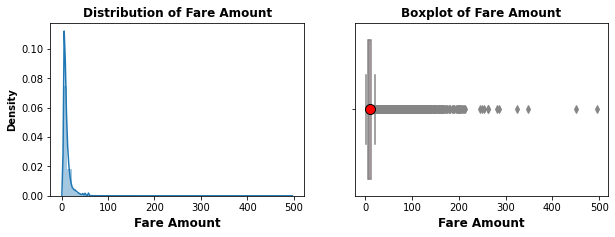

In [201]:
plt.figure(figsize=(10,7))

plt.subplot(221) #distribution
sns.distplot(df['fare_amount'])
plt.xlabel('Fare Amount', size=12, fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('Distribution of Fare Amount', fontweight='bold')

plt.subplot(222)
sns.boxplot(x='fare_amount', data=df, color='pink', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.title('Boxplot of Fare Amount', fontweight='bold')
plt.xlabel('Fare Amount', size=12, fontweight='bold')

plt.show()



---

As we can see on plots data is highly right skewed and have lots of outliers which can deceive the training process of ML models, resulting in less accurate models and eventually bad performance. To avoid this I will drop outliers.

For this I need to count outliers boundary - edge after with the value can be considered as outlier. As it was mentioned the data is highly right skewed that's why I need to count just upper extreme boundary:

```Interquartile Range(IQR) = Q3(75th percentile) - Q1(25th percentile)```

```Upper Boundary = Third Quartile(Q3/75th percentile) + (3* IQR)```


---



In [202]:
IQR = df.fare_amount.quantile(0.75) - df.fare_amount.quantile(0.25)
boundary = df.fare_amount.quantile(0.75) + 3*IQR
print('Upper boundary is $', boundary)

Upper boundary is $ 32.0


In [203]:
df[df.fare_amount>boundary].shape

(43574, 14)



---

About 4% of data can be counted as outliers what is acceptable for this project. I will drop these entities.


---



In [204]:
df = df[df.fare_amount<boundary]
print('df.shape: ',df.shape)

df.shape:  (970388, 14)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


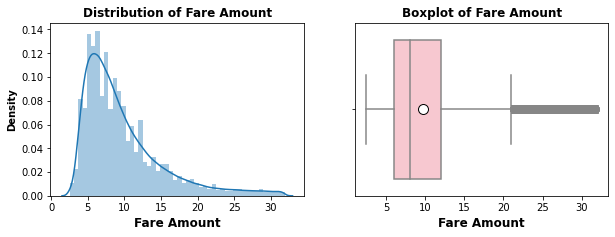

In [205]:
plt.figure(figsize=(10,7))

plt.subplot(221) #distribution
sns.distplot(df['fare_amount'])
plt.xlabel('Fare Amount', size=12, fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('Distribution of Fare Amount', fontweight='bold')

plt.subplot(222)
sns.boxplot(x='fare_amount', data=df, color='pink', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"White", "markeredgecolor":"black","markersize":"10"})
plt.title('Boxplot of Fare Amount', fontweight='bold')
plt.xlabel('Fare Amount', size=12, fontweight='bold')


plt.show()

---

```fare_amount``` distribution looks more realistic now. Data is still a bit skewed, but it's acceptable.

---

### Coordinate Columnns

Let's check distributions of coordinate columns.

---

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

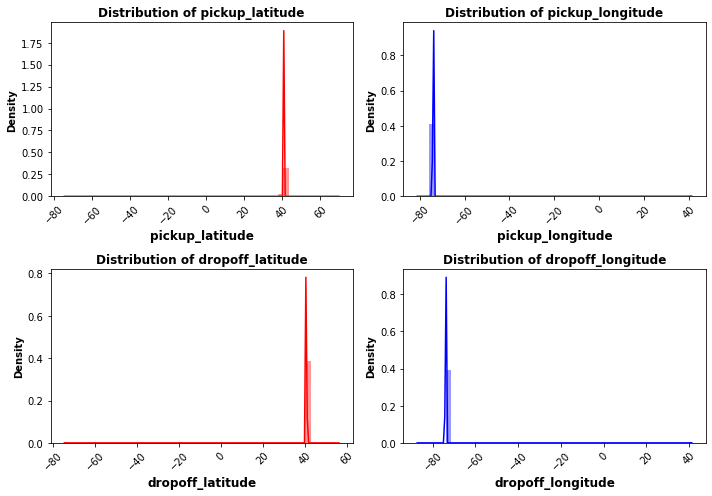

In [206]:
plt.figure(figsize=(7,7))

coor_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
colors=['red', 'blue']

for i in range (4):
  plt.subplot(221+i) 
  sns.distplot(df[coor_cols[i]], color=colors[i%2])
  plt.xticks(rotation=45)
  plt.title('Distribution of {}'.format(coor_cols[i]), fontweight='bold')
  plt.xlabel('{}'.format(coor_cols[i]), size=12, fontweight='bold')
  plt.ylabel('Density', fontweight='bold')

plt.tight_layout() #to avoid overlay
plt.show()




---

As we can see each coordinate column has extreme values which we need to get rid of.

---



In [207]:
print('Column name: min [lower boundary, upper boundary] max')
for var in coor_cols:
  IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
  low_boundary = df[var].quantile(0.75) - 3*IQR
  up_boundary = df[var].quantile(0.75) + 3*IQR
  print('{}: {:.3f} [{:.3f}, {:.3f}] {:.3f}'.format(var, df[var].min(), low_boundary, up_boundary, df[var].max()))

Column name: min [lower boundary, upper boundary] max
pickup_latitude: -74.017 [40.677, 40.858] 69.400
pickup_longitude: -80.617 [-74.038, -73.901] 40.813
dropoff_latitude: -74.017 [40.673, 40.864] 55.783
dropoff_longitude: -86.804 [-74.042, -73.892] 40.851




---

Let's drop all entities with outliers in coordinate columns.

---



In [208]:
df = df.loc[(df.pickup_latitude > 40.677) & (df.pickup_latitude < 40.858)]
df = df.loc[(df.pickup_longitude > -74.038) & (df.pickup_longitude < -73.901)]
df = df.loc[(df.dropoff_latitude > 40.673) & (df.dropoff_latitude < 40.864)]
df = df.loc[(df.dropoff_longitude > -74.042) & (df.dropoff_longitude < -73.892)]
print('df.shape: ', df.shape)

df.shape:  (928029, 14)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

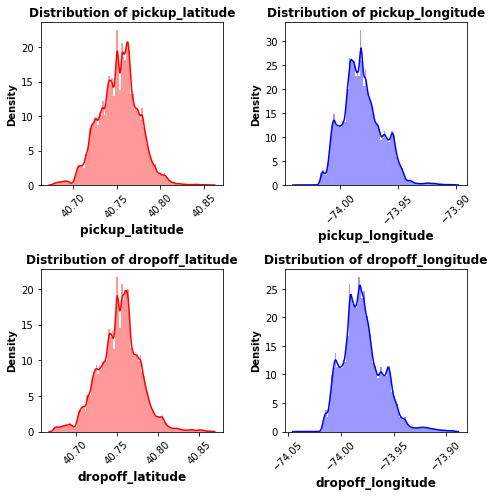

In [211]:
plt.figure(figsize=(7,7))

coor_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
colors=['red', 'blue']

for i in range (4):
  plt.subplot(221+i) 
  sns.distplot(df[coor_cols[i]], color=colors[i%2], bins=100)
  plt.xticks(rotation=45)
  plt.title('Distribution of {}'.format(coor_cols[i]), fontweight='bold')
  plt.xlabel('{}'.format(coor_cols[i]), size=12, fontweight='bold')
  plt.ylabel('Density', fontweight='bold')

plt.tight_layout() #to avoid overlay
plt.show()



---

Now coordinate columns are close to normally ditribution.

---





###Passenger_count column


In [212]:
df.passenger_count.value_counts()

1    646222
2    136457
5     65095
3     40762
4     19958
6     19535
Name: passenger_count, dtype: int64

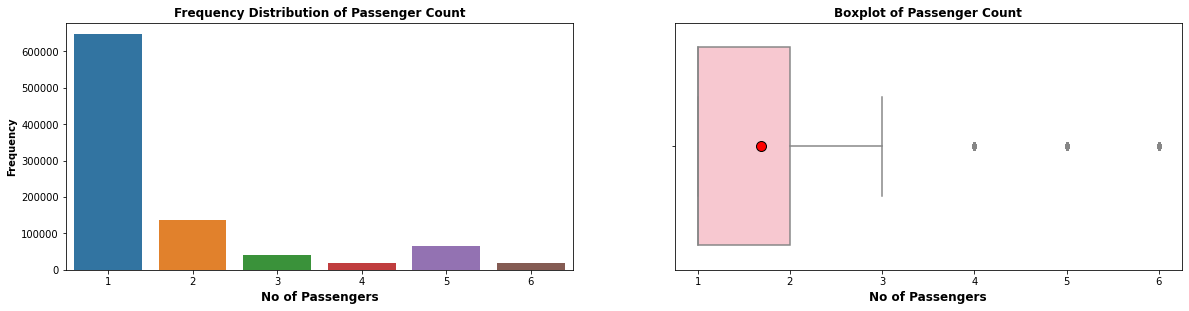

In [213]:
#passenger_count distribution
plt.figure(figsize=(20,10))

plt.subplot(221)
sns.countplot(x='passenger_count', data=df)
plt.title('Frequency Distribution of Passenger Count', fontweight='bold')
plt.xlabel('No of Passengers', size=12, fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')

plt.subplot(222)
sns.boxplot(x='passenger_count', data=df, color='pink', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.title('Boxplot of Passenger Count', fontweight='bold')
plt.xlabel('No of Passengers', size=12, fontweight='bold')


plt.show()



---

**Notes:** 
* majority of rides are made by 1 passenger
* rides with 4 and more passengers could be counted as outliers

---



### Datetime columns

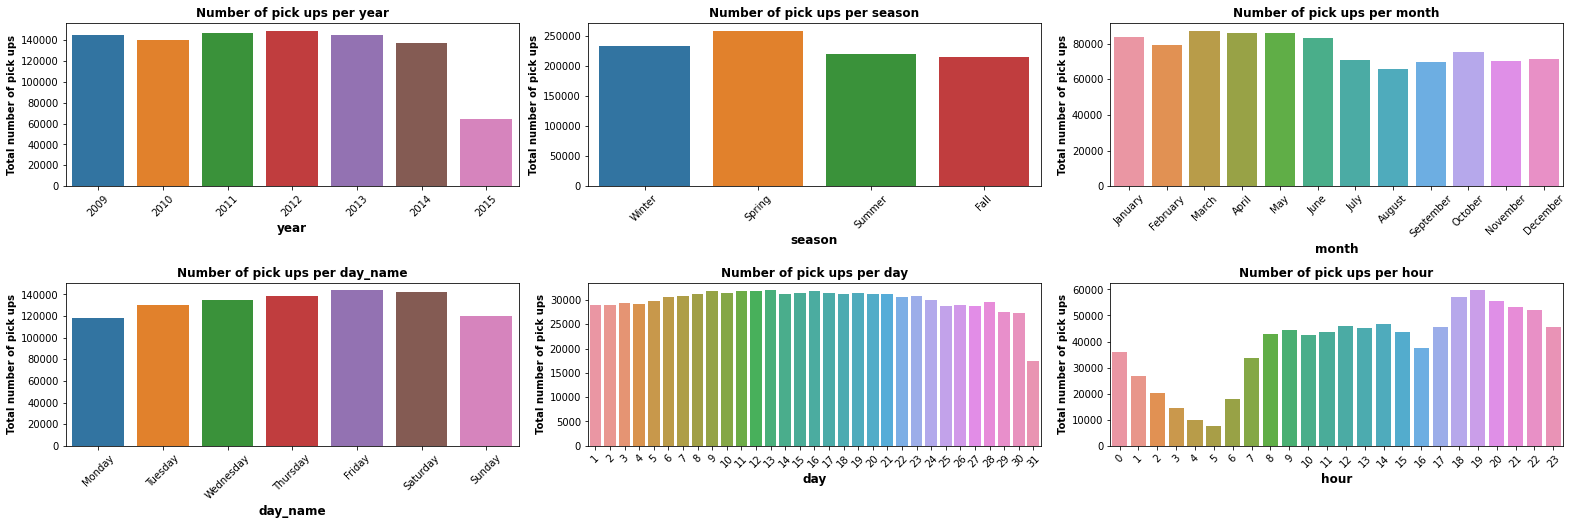

In [217]:
plt.figure(figsize=(22, 10))

datetime_cols = ['year', 'season', 'month', 'day_name', 'day', 'hour']
orders = [None, ['Winter', 'Spring', 'Summer', 'Fall'], 
          ['January', "February", 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], None, None]

for i in range(6):
  plt.subplot(331+i)
  sns.countplot(x=df[datetime_cols[i]], order=orders[i])
  plt.title('Number of pick ups per {}'.format(datetime_cols[i]), fontweight='bold')
  plt.xlabel('{}'.format(datetime_cols[i]), size=12, fontweight='bold')
  plt.xticks(rotation=45)
  plt.ylabel('Total number of pick ups', fontweight='bold')

plt.tight_layout() #to avoid overlay
plt.show()

In [218]:
df[df.year==2015]['season'].value_counts()

Spring    33048
Winter    21130
Summer    10447
Name: season, dtype: int64



---

**Notes:**
* decrease of rides in 2015 is explained by lack of data for particular year (info about just 3/4 of the year exists)
* in spring people take taxi rides more often
* number of pick ups in first half of the year is higher than in the 2nd one
* number of taxi rides made on Sunday and Monday is less than other days with peak on Friday
* by the end of the month taxi usage decreases
* morning rush hour (7am-10am) has much less taxi demand than expected, the highest number of pick ups is at evening (after 7pm)

---



### Distance Column

Let's check distribution of ```distance```. For this I will create 2 plots: distribution plot and boxplot.

---

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


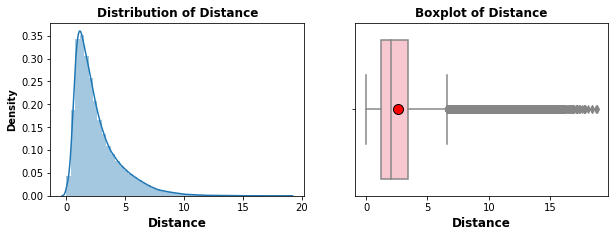

In [219]:
plt.figure(figsize=(10,7))

plt.subplot(221) #distribution
sns.distplot(df['distance'])
plt.xlabel('Distance', size=12, fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('Distribution of Distance', fontweight='bold')

plt.subplot(222)
sns.boxplot(x='distance', data=df, color='pink', showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"Red", "markeredgecolor":"black","markersize":"10"})
plt.title('Boxplot of Distance', fontweight='bold')
plt.xlabel('Distance', size=12, fontweight='bold')

plt.show()

---


Distribution of ```distance`` is skewed. Let's cut outliers (~0.5%)

---

In [223]:
IQR = df.distance.quantile(0.75) - df.distance.quantile(0.25)
boundary = df.distance.quantile(0.75) + 3*IQR
print('Upper boundary is {:.2f}m'.format(boundary))

Upper boundary is 9.85m


In [227]:
df = df[df.distance<=boundary]
print('df.shape: ', df.shape)
df.head()

df.shape:  (922322, 14)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,season,month,day,day_name,hour,rush_hour,distance
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,Winter,January,5,Tuesday,16,1,8.450
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,Summer,August,18,Thursday,0,0,1.390
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,Spring,April,21,Saturday,4,0,2.799
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,Spring,March,9,Tuesday,7,1,1.999
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,2011,Winter,January,6,Thursday,9,1,3.787


## Data Relationship

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/pe44enka/TaxiFarePrediction/master/data/clean_train.csv')
print('df.shape: ', df.shape)
df.head()

### Passenger Count vs Datetime columns

In [ ]:
plt.figure(figsize=(20,10))

#year
plt.subplot(331)
sns.barplot(x='year', y='passenger_count', data=df)
plt.title('Passenger Count per Year', fontweight='bold')
plt.xlabel('Year', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')

#season
plt.subplot(332)
sns.barplot(x='season', y='passenger_count', data=df, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Passenger Count per Season', fontweight='bold')
plt.xlabel('Season', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')

#month
plt.subplot(333)
sns.barplot(x='month', y='passenger_count', data=df, order=['January', "February", 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Passenger Count per Month', fontweight='bold')
plt.xlabel('month', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')
plt.xticks(rotation=45)

#day
plt.subplot(334)
sns.barplot(x='day', y='passenger_count', data=df)
plt.title('Passenger Count per Date', fontweight='bold')
plt.xlabel('Date', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')

#day_name
plt.subplot(335)
sns.barplot(x='day_name', y='passenger_count', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Passenger Count per Week Day', fontweight='bold')
plt.xlabel('Week Day', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')

#hour
plt.subplot(336)
sns.barplot(x='hour', y='passenger_count', data=df)
plt.title('Passenger Count per Hour', fontweight='bold')
plt.xlabel('Hour', size=12, fontweight='bold')
plt.ylabel('Passenger Count', fontweight='bold')

plt.tight_layout() #to avoid overlay
plt.show()

### Target Feature

#### Fare Amount vs Datetime Columns

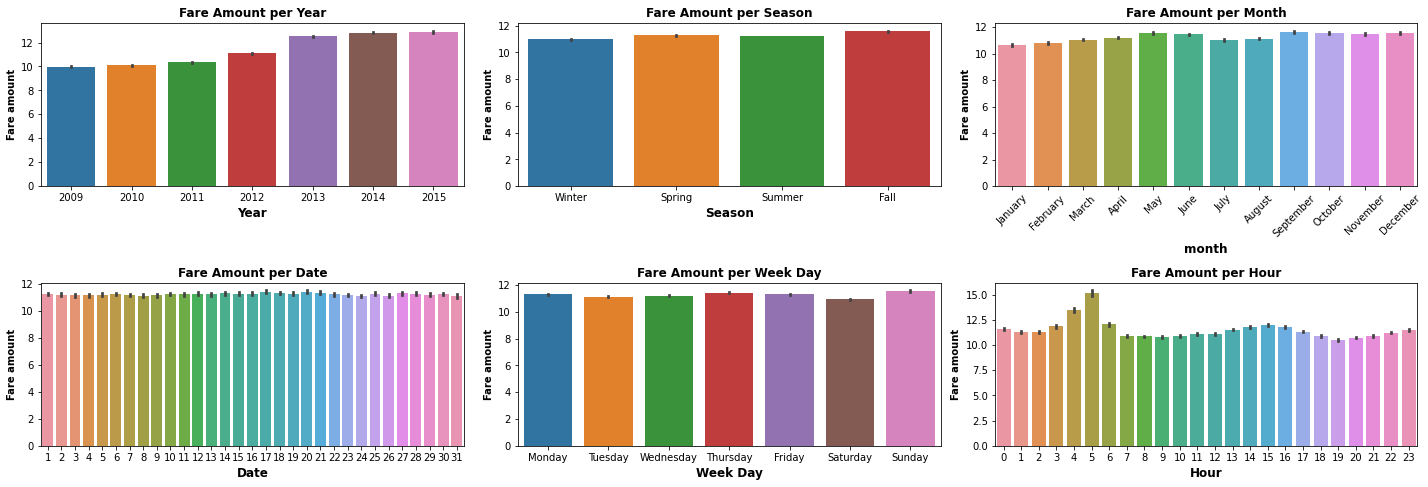

In [364]:
plt.figure(figsize=(20,10))

#year
plt.subplot(331)
sns.barplot(x='year', y='fare_amount', data=df)
plt.title('Fare Amount per Year', fontweight='bold')
plt.xlabel('Year', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

#season
plt.subplot(332)
sns.barplot(x='season', y='fare_amount', data=df, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Fare Amount per Season', fontweight='bold')
plt.xlabel('Season', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

#month
plt.subplot(333)
sns.barplot(x='month', y='fare_amount', data=df, order=['January', "February", 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title('Fare Amount per Month', fontweight='bold')
plt.xlabel('month', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')
plt.xticks(rotation=45)

#day
plt.subplot(334)
sns.barplot(x='day', y='fare_amount', data=df)
plt.title('Fare Amount per Date', fontweight='bold')
plt.xlabel('Date', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

#day_name
plt.subplot(335)
sns.barplot(x='day_name', y='fare_amount', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Fare Amount per Week Day', fontweight='bold')
plt.xlabel('Week Day', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

#hour
plt.subplot(336)
sns.barplot(x='hour', y='fare_amount', data=df)
plt.title('Fare Amount per Hour', fontweight='bold')
plt.xlabel('Hour', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

plt.tight_layout() #to avoid overlay
plt.show()



---

**Notes:** 
* fare amount increases through years, there is relatively big jump in prices between 2012 and 2013
* there is nearly no difference in fare amount between seasons
* there are some fluctuations in price between months

---



#### Fare Amount vs Passengers Count

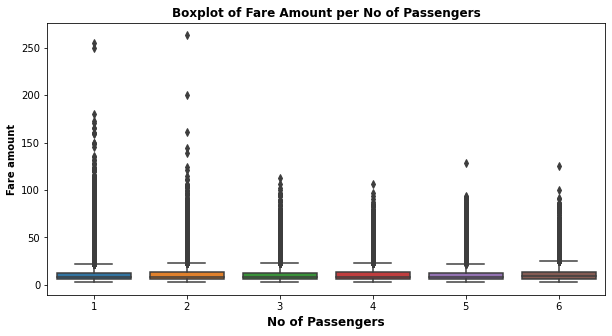

In [330]:
plt.figure(figsize=(10,5))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Boxplot of Fare Amount per No of Passengers', fontweight='bold')
plt.xlabel('No of Passengers', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

plt.show()



---

Let's have closer look by cutting majority of outliers.

---



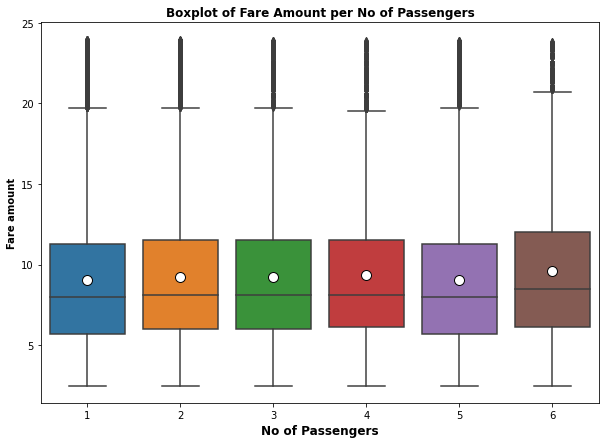

In [318]:
plt.figure(figsize=(10,7))
sns.boxplot(x='passenger_count', y='fare_amount', data=df[df.fare_amount<24], showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"White", "markeredgecolor":"black","markersize":"10"})
plt.title('Boxplot of Fare Amount per No of Passengers', fontweight='bold')
plt.xlabel('No of Passengers', size=12, fontweight='bold')
plt.ylabel('Fare amount', fontweight='bold')

plt.show()



---

**Note:** the mean fare amount as slightly higher when number of passengers is 6. But the total number of rides with 6 passengers are pretty low in comparison with other number of passengers.

**Conclusion:** there is no significant variation of taxi fare between passenger number.

---



# Results



While analyzing I dropped some data. Let's check how much.

---



In [60]:
percent = 100-(df.shape[0]*100/raw_df.shape[0])
print('Cleaning process dicreased data on {:.2f}%'.format(percent))

Cleaning process dicreased data on 4.27%




---

With all my data manipulation I lost less than 5% of data. But at the same time I got clean data to train future model. So it's acceptable for this project, but probably not acceptable for another one.

---



After finishing process of cleaning data let's save the result to avoid repeating the whole thing in the future.

---

## Save Clean Data

In [230]:
#save df
df.to_csv('clean_train.csv', index=False)

## Feature Extracting Function

After creating and training model we will have to apply it on the test data to get predictions. To do so we will need to convert test data  to the same format as we did with train data. For this purpose lets create a function that will do it for us:
* drop ```key``` column
* convert ```pickup_datetime``` into datetime data type
* create ```year```, ```season```, ```month```, ```day```, ```day_name```, ```hour```, ```rush_hour``` out of ```pickup_datetime```
* create ```distance``` column out of coordinate columns

---

In [215]:
def clean_data(df):

  df.drop(columns = ['key'], inplace=True) #drop key column

  df.pickup_datetime = pd.to_datetime(df.pickup_datetime) #convert dtype to datetime

  #creating year, season, month, day, day_name, hour columns
  df['year'] = df.pickup_datetime.dt.year #year
  seasons = ['Winter', 'Spring', 'Summer', 'Fall'] 
  df['season'] = [seasons[i-1] for i in (df.pickup_datetime.dt.month%12// 3 + 1).values] #season
  df['month'] = df.pickup_datetime.dt.month_name() #month
  df['day'] = df.pickup_datetime.dt.day #day
  df['day_name'] = df.pickup_datetime.dt.day_name() #day name
  df['hour'] = df.pickup_datetime.dt.hour #hour
  
  #creating rush hour column
  rush_hour = []
  for i in df.hour.values:
    if i in range(7,11):
      rush_hour.append(1)
    elif i in range(15,20):
      rush_hour.append(1)
    else:
      rush_hour.append(0)
  df['rush_hour'] = rush_hour # rush hour
  
  df.drop(columns=['pickup_datetime'], inplace=True) # drop donor pickup_datetime column

  #creating distance column
  distance = []
  for i in range(df.shape[0]):
    coordA = [df.pickup_latitude.iloc[i], df.pickup_longitude.iloc[i]]
    coordB = [df.dropoff_latitude.iloc[i], df.dropoff_longitude.iloc[i]]
    distance.append(round(float(great_circle(coordA, coordB).kilometers), 3))  
  df['distance'] = distance #create a column with distance for each ride
  
  df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True) #drop donor columns

  return df